 ## Here are the tests for the different detectors

In [9]:
%matplotlib inline

# Import necessary dependencies
import cv2
import numpy as np
import unittest
import sys
import os
import matplotlib.pyplot as plt

# Import the necessary classes
from detectors import RedCapDetector 
from detectors import YOLODetector
from detectors import find_intersecting_human

# from segmentors import DeepLabSegmentor
# from segmentors import MaskRCNNSegmentor
# from segmentors/Yolact_Segmentor import YOLACTSegmentor

# interactive notebook widgets
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
def imshow(image, cmap=None):
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image_rgb, cmap)
  plt.axis('off')  # Hide axis for better visualization
  plt.show()

In [3]:
YoloDetector = YOLODetector(device='cuda')

/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarnin

In [4]:
test_image = cv2.imread('_test_data/test1.jpg')
imshow(test_image)

In [5]:
"""
Test if the red cap detector correctly identifies a bounding box for a red cap.
"""
red_cap_detector = RedCapDetector()

red_cap_boxes = red_cap_detector.detect(test_image, hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
print("Red Cap Detector Output:", red_cap_boxes)
# Draw the bounding box on the image knowing that the red_cap_detector returns a bounding box in the form (x, y, w, h) where the red cap is located. If no cap is found, returns None.

if red_cap_boxes is not None:
    test_image_bis = test_image.copy()
    for box in red_cap_boxes:
        x, y, w, h = box
        cv2.rectangle(test_image_bis, (x, y), (x+w, y+h), (0, 255, 0), 2)
        # cv2.putText(test_image_bis, 'Red Cap', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    imshow(test_image_bis)

Red Cap Detector Output: [(424, 451, 83, 49)]


In [6]:
"""
Test if the human detector correctly identifies a bounding box for a person.
"""

human_boxes = YoloDetector.detect(test_image)
print("Human Detector Output:", human_boxes)
# Draw the bounding box on the image knowing that the red_cap_detector returns a bounding box in the form (x, y, w, h) where the red cap is located. If no cap is found, returns None.

if human_boxes is not None:
    test_image_bis = test_image.copy()
    for box in human_boxes:
        x, y, w, h = box
        cv2.rectangle(test_image_bis, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    imshow(test_image_bis)


Will run on cuda


/users/eleves-b/2022/mathias.perez/Ikomia/Plugins/Python/infer_yolo_v7/yolov7/utils/torch_utils.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(weigh

Fusing layers... 


/users/eleves-b/2022/mathias.perez/Desktop/INF573-MakeBenardDisappear/ikomia_env/lib64/python3.9/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Workflow Untitled run successfully in 722.633515 ms.
Human Detector Output: [(498, 759, 161, 264), (672, 729, 156, 294), (0, 797, 126, 226), (416, 451, 119, 474), (611, 506, 111, 452), (222, 796, 162, 227), (841, 813, 179, 210), (773, 513, 151, 486), (295, 422, 84, 372), (93, 456, 102, 460), (185, 594, 129, 420), (491, 344, 92, 368), (696, 394, 88, 372), (862, 437, 104, 347)]


Intersections: [(416, 451, 119, 474)]


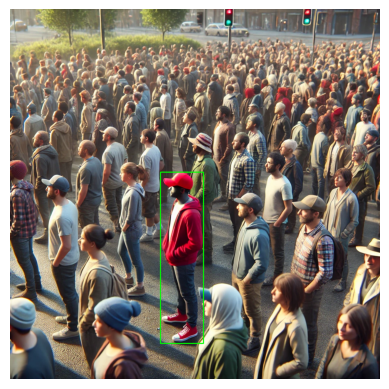

In [10]:
"""
Test if the combined detector gives good results
"""

intersections = find_intersecting_human(red_cap_boxes, human_boxes)

print("Intersections:", intersections)
# Draw the bounding box on the image knowing that the red_cap_detector returns a bounding box in the form (x, y, w, h) where the red cap is located. If no cap is found, returns None.

if intersections is not None:
    test_image_bis = test_image.copy()
    for box in intersections:
        x, y, w, h = box
        cv2.rectangle(test_image_bis, (x, y), (x+w, y+h), (0, 255, 0), 2)
        # cv2.putText(test_image_bis, 'Human', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    
    imshow(test_image_bis)

Will run on cuda
Fusing layers... 
Workflow Untitled run successfully in 193.206935 ms.


/users/eleves-b/2022/mathias.perez/Ikomia/Plugins/Python/infer_yolo_v7/yolov7/utils/torch_utils.py:276: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(weigh

Workflow Untitled run successfully in 31.206701 ms.
Workflow Untitled run successfully in 30.664901 ms.
Workflow Untitled run successfully in 31.850561 ms.


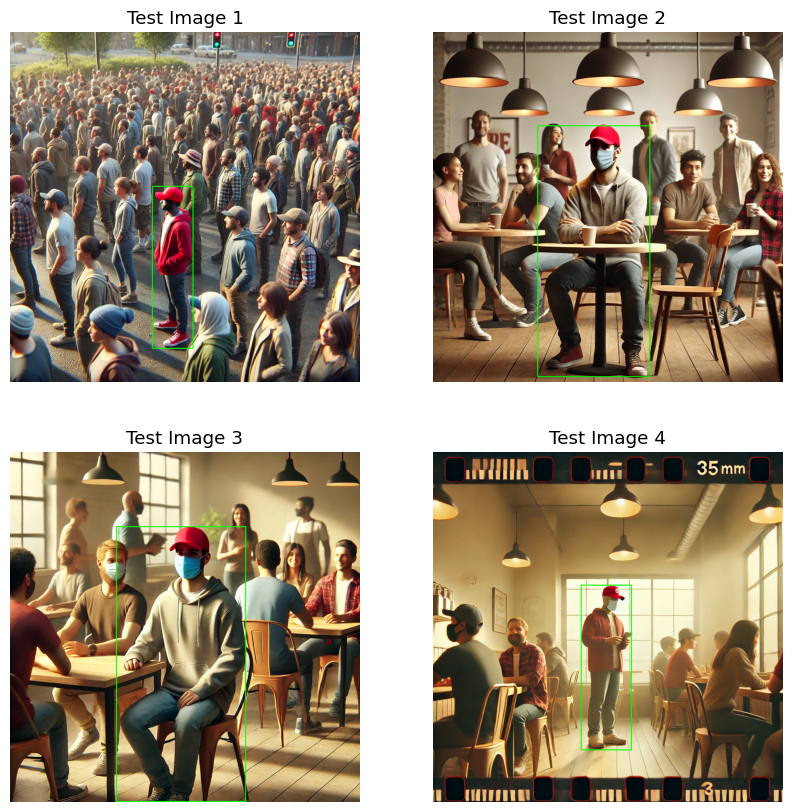

In [13]:
# Let's test the find intersecting human function for all test cases
test_image1 = cv2.imread('_test_data/test1.jpg') 
test_image2 = cv2.imread('_test_data/test2.jpg')
test_image3 = cv2.imread('_test_data/test3.jpg')
test_image4 = cv2.imread('_test_data/test4.jpg')

human_detector = YOLODetector(device='cuda')

red_cap_boxes_1 = red_cap_detector.detect(test_image1,hue_range=(0, 5), alt_hue_range=(170, 180))
red_cap_boxes_2 = red_cap_detector.detect(test_image2,hue_range=(0, 5), alt_hue_range=(170, 180))
red_cap_boxes_3 = red_cap_detector.detect(test_image3, hue_range=(0, 5), alt_hue_range=(170, 180))
red_cap_boxes_4 = red_cap_detector.detect(test_image4,hue_range=(0, 5), alt_hue_range=(170, 180))

human_boxes_1 = human_detector.detect(test_image1)
human_boxes_2 = human_detector.detect(test_image2)
human_boxes_3 = human_detector.detect(test_image3)
human_boxes_4 = human_detector.detect(test_image4)

intersections_1 = find_intersecting_human(red_cap_boxes_1, human_boxes_1)
intersections_2 = find_intersecting_human(red_cap_boxes_2, human_boxes_2)
intersections_3 = find_intersecting_human(red_cap_boxes_3, human_boxes_3)
intersections_4 = find_intersecting_human(red_cap_boxes_4, human_boxes_4)

if intersections_1 is not None:
    test_image_bis1 = test_image1.copy()
    for box in intersections_1:
        x, y, w, h = box
        cv2.rectangle(test_image_bis1, (x, y), (x+w, y+h), (0, 255, 0), 2)

if intersections_2 is not None:
    test_image_bis2 = test_image2.copy()
    for box in intersections_2:
        x, y, w, h = box
        cv2.rectangle(test_image_bis2, (x, y), (x+w, y+h), (0, 255, 0), 2)

if intersections_3 is not None:
    test_image_bis3 = test_image3.copy()
    for box in intersections_3:
        x, y, w, h = box
        cv2.rectangle(test_image_bis3, (x, y), (x+w, y+h), (0, 255, 0), 2)

if intersections_4 is not None:
    test_image_bis4 = test_image4.copy()
    for box in intersections_4:
        x, y, w, h = box
        cv2.rectangle(test_image_bis4, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # Display the images in a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
axs[0, 0].axis('off')
axs[0, 0].set_title('Test Image 1')

axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
axs[0, 1].axis('off')
axs[0, 1].set_title('Test Image 2')

axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
axs[1, 0].axis('off')
axs[1, 0].set_title('Test Image 3')

axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
axs[1, 1].axis('off')
axs[1, 1].set_title('Test Image 4')

plt.show()





## Let's have more testing for the red cap detector by playing with the multiple parameters it has

In [ ]:
test_image1 = cv2.imread('_test_data/test1.jpg') 
test_image2 = cv2.imread('_test_data/test2.jpg')
test_image3 = cv2.imread('_test_data/test3.jpg')
test_image4 = cv2.imread('_test_data/test4.jpg')

In [ ]:
@interact(min_size = (0, 1000, 10), min_circularity = (0, 1, 0.1))
def imshow_with_red_cap(min_size, min_circularity):
    red_cap_boxes_1 = red_cap_detector.detect(test_image1,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=min_size, min_circularity=min_circularity)
    red_cap_boxes_2 = red_cap_detector.detect(test_image2,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=min_size, min_circularity=min_circularity)
    red_cap_boxes_3 = red_cap_detector.detect(test_image3, hue_range=(0, 5), alt_hue_range=(170, 180),min_size=min_size, min_circularity=min_circularity)
    red_cap_boxes_4 = red_cap_detector.detect(test_image4,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=min_size, min_circularity=min_circularity)

    if red_cap_boxes_1 is not None:
        test_image_bis1 = test_image1.copy()
        for box in red_cap_boxes_1:
            x, y, w, h = box
            cv2.rectangle(test_image_bis1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if red_cap_boxes_2 is not None:
        test_image_bis2 = test_image2.copy()
        for box in red_cap_boxes_2:
            x, y, w, h = box
            cv2.rectangle(test_image_bis2, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if red_cap_boxes_3 is not None:
        test_image_bis3 = test_image3.copy()
        for box in red_cap_boxes_3:
            x, y, w, h = box
            cv2.rectangle(test_image_bis3, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if red_cap_boxes_4 is not None:
        test_image_bis4 = test_image4.copy()
        for box in red_cap_boxes_4:
            x, y, w, h = box
            cv2.rectangle(test_image_bis4, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # Display the images in a single plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Test Image 1')

    axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Test Image 2')

    axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis('off')
    axs[1, 0].set_title('Test Image 3')

    axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Test Image 4')

    plt.show()

# Results :
# Circularity needs to be at max 0.3
# Min size at 620 detects the caps only

interactive(children=(IntSlider(value=500, description='min_size', max=1000, step=10), FloatSlider(value=0.0, …

## Lets do the same thing for the human detector now

In [ ]:
@interact(conf = (0, 1, 0.1), iou = (0, 1, 0.1))
def imshow_with_yolo(conf, iou):
    human_boxes_1 = human_detector.detect(test_image1, conf, iou)
    human_boxes_2 = human_detector.detect(test_image2, conf, iou)
    human_boxes_3 = human_detector.detect(test_image3, conf, iou)
    human_boxes_4 = human_detector.detect(test_image4, conf, iou)


    if human_boxes_1 is not None:
        test_image_bis1 = test_image1.copy()
        for box in human_boxes_1:
            x, y, w, h = box
            cv2.rectangle(test_image_bis1, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    if human_boxes_2 is not None:
        test_image_bis2 = test_image2.copy()
        for box in human_boxes_2:
            x, y, w, h = box
            cv2.rectangle(test_image_bis2, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if human_boxes_3 is not None:
        test_image_bis3 = test_image3.copy()
        for box in human_boxes_3:
            x, y, w, h = box
            cv2.rectangle(test_image_bis3, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if human_boxes_4 is not None:
        test_image_bis4 = test_image4.copy()
        for box in human_boxes_4:
            x, y, w, h = box
            cv2.rectangle(test_image_bis4, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # Display the images in a single plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Test Image 1')

    axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Test Image 2')

    axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis('off')
    axs[1, 0].set_title('Test Image 3')

    axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Test Image 4')

    plt.show()

# Results :
# Conf needs to be at 0.5
# IOU needs to be at 0.5

interactive(children=(FloatSlider(value=0.0, description='conf', max=1.0), FloatSlider(value=0.0, description=…

interactive(children=(FloatSlider(value=0.0, description='conf', max=1.0), FloatSlider(value=0.0, description=…

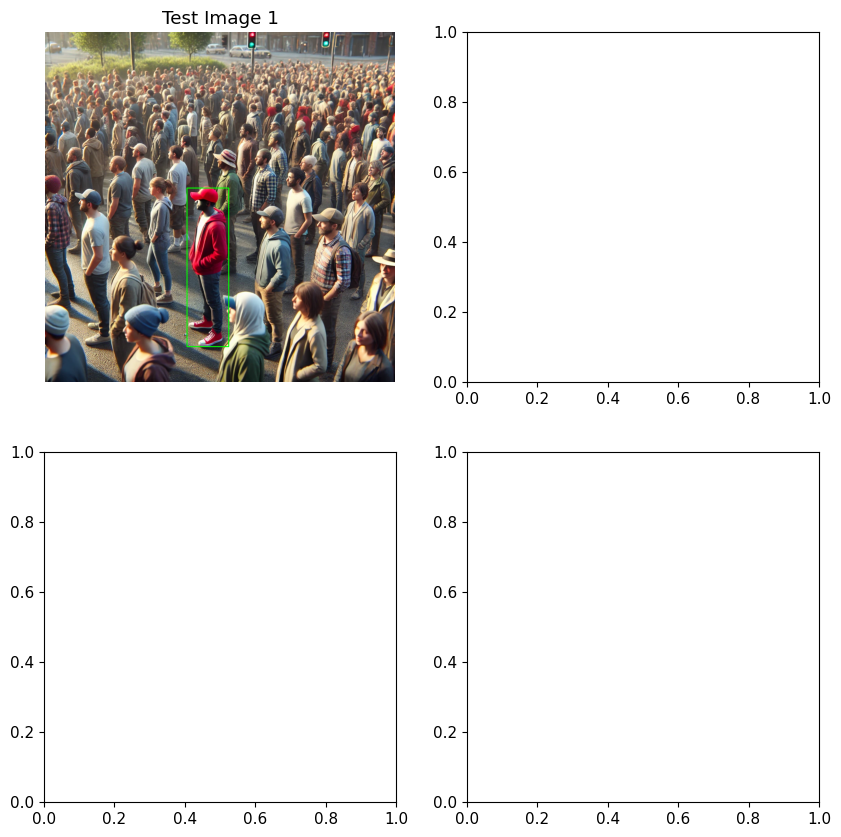

In [ ]:
@interact(conf = (0, 1, 0.1), iou = (0, 1, 0.1))
def imshow_with_yolo(conf, iou):
    red_cap_boxes_1 = red_cap_detector.detect(test_image1,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
    red_cap_boxes_2 = red_cap_detector.detect(test_image2,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
    red_cap_boxes_3 = red_cap_detector.detect(test_image3, hue_range=(0, 5), alt_hue_range=(170, 180),min_size=620, min_circularity=0.3)
    red_cap_boxes_4 = red_cap_detector.detect(test_image4,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)

    
    human_boxes_1 = human_detector.detect(test_image1, conf, iou)
    human_boxes_2 = human_detector.detect(test_image2, conf, iou)
    human_boxes_3 = human_detector.detect(test_image3, conf, iou)
    human_boxes_4 = human_detector.detect(test_image4, conf, iou)

    intersections_1 = find_intersecting_human(red_cap_boxes_1, human_boxes_1)
    intersections_2 = find_intersecting_human(red_cap_boxes_2, human_boxes_2)
    intersections_3 = find_intersecting_human(red_cap_boxes_3, human_boxes_3)
    intersections_4 = find_intersecting_human(red_cap_boxes_4, human_boxes_4)


    if intersections_1 is not None:
        test_image_bis1 = test_image1.copy()
        for box in intersections_1:
            x, y, w, h = box
            cv2.rectangle(test_image_bis1, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if intersections_2 is not None:
        test_image_bis2 = test_image2.copy()
        for box in intersections_2:
            x, y, w, h = box
            cv2.rectangle(test_image_bis2, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if intersections_3 is not None:
        test_image_bis3 = test_image3.copy()
        for box in intersections_3:
            x, y, w, h = box
            cv2.rectangle(test_image_bis3, (x, y), (x+w, y+h), (0, 255, 0), 2)

    if intersections_4 is not None:
        test_image_bis4 = test_image4.copy()
        for box in intersections_4:
            x, y, w, h = box
            cv2.rectangle(test_image_bis4, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    
    # Display the images in a single plot
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
    axs[0, 0].axis('off')
    axs[0, 0].set_title('Test Image 1')

    axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
    axs[0, 1].axis('off')
    axs[0, 1].set_title('Test Image 2')

    axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
    axs[1, 0].axis('off')
    axs[1, 0].set_title('Test Image 3')

    axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
    axs[1, 1].axis('off')
    axs[1, 1].set_title('Test Image 4')

    plt.show()

# Results :
# Conf needs to be at 0.7
# IOU needs to be more than 0.3 but more detailed testing is needed

In [ ]:
def getSegmented(image):
    red_cap_boxes = red_cap_detector.detect(image,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
    human_boxes = human_detector.detect(image, 0.7, 0.5)
    intersections = find_intersecting_human(red_cap_boxes, human_boxes)
    segmented_image = segmentor.segment(image, intersections)
    return segmented_image

indices [ 0  1  2  3  4  5  6  7  8  9 10 11]
indices [0 1 2 3 4 5 6]
indices [0 1 2 3 4 5 6 7 8]
indices [0 1 2 3 4]


Text(0.5, 1.0, 'Test Image 4')

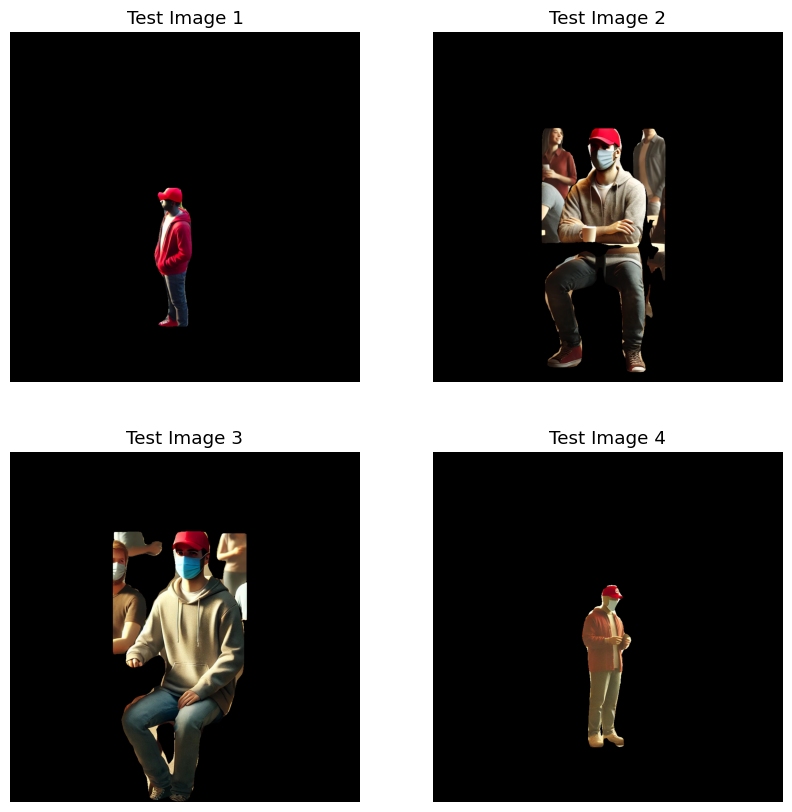

In [ ]:
segmentor = MaskRCNNSegmentor()

red_cap_boxes_1 = red_cap_detector.detect(test_image1,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
red_cap_boxes_2 = red_cap_detector.detect(test_image2,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)
red_cap_boxes_3 = red_cap_detector.detect(test_image3, hue_range=(0, 5), alt_hue_range=(170, 180),min_size=620, min_circularity=0.3)
red_cap_boxes_4 = red_cap_detector.detect(test_image4,hue_range=(0, 5), alt_hue_range=(170, 180), min_size=620, min_circularity=0.3)

    
human_boxes_1 = human_detector.detect(test_image1)
human_boxes_2 = human_detector.detect(test_image2)
human_boxes_3 = human_detector.detect(test_image3)
human_boxes_4 = human_detector.detect(test_image4)

intersections_1 = find_intersecting_human(red_cap_boxes_1, human_boxes_1)
intersections_2 = find_intersecting_human(red_cap_boxes_2, human_boxes_2)
intersections_3 = find_intersecting_human(red_cap_boxes_3, human_boxes_3)
intersections_4 = find_intersecting_human(red_cap_boxes_4, human_boxes_4)

segmented_image1 = segmentor.segment(test_image1, intersections_1)
segmented_image2 = segmentor.segment(test_image2, intersections_2)
segmented_image3 = segmentor.segment(test_image3, intersections_3)
segmented_image4 = segmentor.segment(test_image4, intersections_4)


test_image_bis1 = test_image1.copy()
test_image_bis1[segmented_image1 == 0] = 0

test_image_bis2 = test_image2.copy()
test_image_bis2[segmented_image2 == 0] = 0

test_image_bis3 = test_image3.copy()
test_image_bis3[segmented_image3 == 0] = 0

test_image_bis4 = test_image4.copy()
test_image_bis4[segmented_image4 == 0] = 0

# Display the images in a single plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(cv2.cvtColor(test_image_bis1, cv2.COLOR_BGR2RGB))
axs[0, 0].axis('off')
axs[0, 0].set_title('Test Image 1')

axs[0, 1].imshow(cv2.cvtColor(test_image_bis2, cv2.COLOR_BGR2RGB))
axs[0, 1].axis('off')
axs[0, 1].set_title('Test Image 2')

axs[1, 0].imshow(cv2.cvtColor(test_image_bis3, cv2.COLOR_BGR2RGB))
axs[1, 0].axis('off')
axs[1, 0].set_title('Test Image 3')

axs[1, 1].imshow(cv2.cvtColor(test_image_bis4, cv2.COLOR_BGR2RGB))
axs[1, 1].axis('off')
axs[1, 1].set_title('Test Image 4')